In [4]:
import torch
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))


CUDA: True
GPU: Tesla T4


In [6]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [8]:
!mkdir -p '/content/drive/MyDrive/FlowerGAN_Project'


In [9]:
!wget -q https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -O /content/flowers.tgz
!tar -xzf /content/flowers.tgz -C /content/drive/MyDrive/FlowerGAN_Project/
!mv "/content/drive/MyDrive/FlowerGAN_Project/flower_photos" "/content/drive/MyDrive/FlowerGAN_Project/flowers"
print("✅ Flowers dataset downloaded and ready!")


✅ Flowers dataset downloaded and ready!


In [10]:
import os
print(os.listdir('/content/drive/MyDrive/FlowerGAN_Project/flowers'))


['roses', 'sunflowers', 'LICENSE.txt', 'tulips', 'daisy', 'dandelion']


In [11]:
data_dir = '/content/drive/MyDrive/FlowerGAN_Project/flowers'

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Classes:", dataset.classes)
print("Total images:", len(dataset))


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Total images: 3670


In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, len(dataset.classes))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNModel().to(device)
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

losses, accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    losses.append(running_loss / len(train_loader))
    accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {acc:.2f}%")

print("✅ Training completed successfully!")


Epoch [1/15] - Loss: 1.3991 - Accuracy: 39.97%
Epoch [2/15] - Loss: 1.0676 - Accuracy: 56.43%
Epoch [3/15] - Loss: 0.9352 - Accuracy: 63.49%
Epoch [4/15] - Loss: 0.8287 - Accuracy: 68.72%
Epoch [5/15] - Loss: 0.7006 - Accuracy: 73.41%
Epoch [6/15] - Loss: 0.5672 - Accuracy: 78.96%
Epoch [7/15] - Loss: 0.4228 - Accuracy: 85.04%
Epoch [8/15] - Loss: 0.2954 - Accuracy: 89.54%
Epoch [9/15] - Loss: 0.2111 - Accuracy: 92.67%
Epoch [10/15] - Loss: 0.1719 - Accuracy: 94.58%
Epoch [11/15] - Loss: 0.1101 - Accuracy: 96.46%
Epoch [12/15] - Loss: 0.0932 - Accuracy: 96.92%
Epoch [13/15] - Loss: 0.0835 - Accuracy: 97.66%
Epoch [14/15] - Loss: 0.0591 - Accuracy: 98.28%
Epoch [15/15] - Loss: 0.0526 - Accuracy: 98.42%
✅ Training completed successfully!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, time, math, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

WORKDIR = '/content/drive/MyDrive/FlowerGAN_Project'
os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'gan_samples'), exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'generated'), exist_ok=True)


Mounted at /content/drive
Device: cuda


In [2]:
data_dir = os.path.join(WORKDIR, 'flowers')   # should already exist
img_size = 64
batch_size = 64

gan_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # DCGAN uses [-1,1] with tanh
])

gan_dataset = datasets.ImageFolder(data_dir, transform=gan_transform)
gan_loader = DataLoader(gan_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

num_classes = len(gan_dataset.classes)
print("Classes:", gan_dataset.classes, "Num images:", len(gan_dataset))


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] Num images: 3670


In [3]:
# Conditional Generator: embed label, concat with z
class Generator(nn.Module):
    def __init__(self, z_dim=100, n_classes=5, img_channels=3, feature_g=64):
        super().__init__()
        self.z_dim = z_dim
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.fc = nn.Linear(z_dim + n_classes, feature_g*8*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(feature_g*8, feature_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*4), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*4, feature_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*2), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        lab = self.label_emb(labels)
        x = torch.cat([z, lab], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.net(x)
        return x

# Conditional Discriminator: expand label to spatial map and concat to image
class Discriminator(nn.Module):
    def __init__(self, n_classes=5, img_channels=3, feature_d=64):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels + n_classes, feature_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d*2, 4, 2, 1),
            nn.BatchNorm2d(feature_d*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*2, feature_d*4, 4, 2, 1),
            nn.BatchNorm2d(feature_d*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*4, 1, 4, 1, 0)
        )

    def forward(self, img, labels):
        b, c, h, w = img.shape
        lab = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # b x n_classes x1x1
        lab_map = lab.expand(-1, -1, h, w)
        x = torch.cat([img, lab_map], dim=1)
        out = self.conv(x)
        return out.view(-1)  # logits


In [4]:
z_dim = 100
G = Generator(z_dim=z_dim, n_classes=num_classes).to(device)
D = Discriminator(n_classes=num_classes).to(device)

lr = 2e-4
optimG = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
optimD = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCEWithLogitsLoss()

print("G params:", sum(p.numel() for p in G.parameters()))
print("D params:", sum(p.numel() for p in D.parameters()))


G params: 3623513
D params: 668890


In [8]:
num_epochs = 50                # You can reduce to 25 for quick test
sample_interval = 5            # Save generated samples every N epochs
z_dim = 100                    # Latent noise dimension (must match Generator)
fixed_z = torch.randn(64, z_dim, device=device)
fixed_labels = torch.arange(0, num_classes, device=device).repeat(64 // num_classes + 1)[:64].long()

for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for real_imgs, labels in tqdm(gan_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        b = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # ============================
        #  Train Discriminator (D)
        # ============================
        D.zero_grad()

        # Real images
        real_logits = D(real_imgs, labels)
        real_targets = torch.ones_like(real_logits, device=device)
        loss_real = criterion(real_logits, real_targets)

        # Fake images
        z = torch.randn(b, z_dim, device=device)
        rand_labels = torch.randint(0, num_classes, (b,), device=device)
        fake_imgs = G(z, rand_labels)
        fake_logits = D(fake_imgs.detach(), rand_labels)
        fake_targets = torch.zeros_like(fake_logits, device=device)
        loss_fake = criterion(fake_logits, fake_targets)

        # Total discriminator loss
        lossD = (loss_real + loss_fake) * 0.5
        lossD.backward()
        optimD.step()

        # ============================
        #  Train Generator (G)
        # ============================
        G.zero_grad()
        gen_logits = D(fake_imgs, rand_labels)
        gen_targets = torch.ones_like(gen_logits, device=device)  # we want D to think fakes are real
        lossG = criterion(gen_logits, gen_targets)
        lossG.backward()
        optimG.step()

        epoch_d_loss += lossD.item() * b
        epoch_g_loss += lossG.item() * b

    # Average losses
    epoch_d_loss /= len(gan_dataset)
    epoch_g_loss /= len(gan_dataset)

    print(f"Epoch {epoch}/{num_epochs} | D_loss: {epoch_d_loss:.4f} | G_loss: {epoch_g_loss:.4f}")

    # ============================
    # Save samples & checkpoints
    # ============================
    if epoch % sample_interval == 0 or epoch == 1:
        G.eval()
        with torch.no_grad():
            imgs = G(fixed_z, fixed_labels).cpu()
            imgs = (imgs + 1) * 0.5  # Rescale from [-1,1] to [0,1]
            grid = make_grid(imgs, nrow=8, normalize=False)
            save_path = os.path.join(WORKDIR, 'gan_samples', f'samples_epoch_{epoch}.png')
            save_image(grid, save_path)
            print(f"💾 Saved sample image to: {save_path}")

        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'G_state': G.state_dict(),
            'D_state': D.state_dict(),
            'G_loss': epoch_g_loss,
            'D_loss': epoch_d_loss
        }, os.path.join(WORKDIR, 'checkpoints', f'gan_epoch_{epoch}.pth'))
        print(f"✅ Checkpoint saved for epoch {epoch}")


Epoch 1/50: 100%|██████████| 58/58 [14:25<00:00, 14.92s/it]


Epoch 1/50 | D_loss: 0.1356 | G_loss: 3.3431
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_1.png
✅ Checkpoint saved for epoch 1


Epoch 2/50: 100%|██████████| 58/58 [00:15<00:00,  3.73it/s]


Epoch 2/50 | D_loss: 0.0174 | G_loss: 4.6960


Epoch 3/50: 100%|██████████| 58/58 [00:15<00:00,  3.85it/s]


Epoch 3/50 | D_loss: 0.0055 | G_loss: 5.6552


Epoch 4/50: 100%|██████████| 58/58 [00:14<00:00,  3.89it/s]


Epoch 4/50 | D_loss: 0.0025 | G_loss: 6.4487


Epoch 5/50: 100%|██████████| 58/58 [00:14<00:00,  3.91it/s]


Epoch 5/50 | D_loss: 0.0013 | G_loss: 7.0698
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_5.png
✅ Checkpoint saved for epoch 5


Epoch 6/50: 100%|██████████| 58/58 [00:15<00:00,  3.85it/s]


Epoch 6/50 | D_loss: 0.0008 | G_loss: 7.5596


Epoch 7/50: 100%|██████████| 58/58 [00:14<00:00,  3.88it/s]


Epoch 7/50 | D_loss: 0.0006 | G_loss: 7.9256


Epoch 8/50: 100%|██████████| 58/58 [00:15<00:00,  3.76it/s]


Epoch 8/50 | D_loss: 0.0004 | G_loss: 8.2226


Epoch 9/50: 100%|██████████| 58/58 [00:16<00:00,  3.52it/s]


Epoch 9/50 | D_loss: 0.0003 | G_loss: 8.4568


Epoch 10/50: 100%|██████████| 58/58 [00:15<00:00,  3.76it/s]


Epoch 10/50 | D_loss: 0.0003 | G_loss: 8.6645
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_10.png
✅ Checkpoint saved for epoch 10


Epoch 11/50: 100%|██████████| 58/58 [00:16<00:00,  3.55it/s]


Epoch 11/50 | D_loss: 0.0002 | G_loss: 8.9178


Epoch 12/50: 100%|██████████| 58/58 [00:14<00:00,  3.87it/s]


Epoch 12/50 | D_loss: 0.0002 | G_loss: 9.1116


Epoch 13/50: 100%|██████████| 58/58 [00:15<00:00,  3.85it/s]


Epoch 13/50 | D_loss: 0.0002 | G_loss: 9.2812


Epoch 14/50: 100%|██████████| 58/58 [00:14<00:00,  3.91it/s]


Epoch 14/50 | D_loss: 0.0001 | G_loss: 9.4961


Epoch 15/50: 100%|██████████| 58/58 [00:14<00:00,  3.92it/s]


Epoch 15/50 | D_loss: 0.0001 | G_loss: 9.6027
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_15.png
✅ Checkpoint saved for epoch 15


Epoch 16/50: 100%|██████████| 58/58 [00:15<00:00,  3.66it/s]


Epoch 16/50 | D_loss: 0.0001 | G_loss: 9.7063


Epoch 17/50: 100%|██████████| 58/58 [00:15<00:00,  3.84it/s]


Epoch 17/50 | D_loss: 0.0001 | G_loss: 9.8774


Epoch 18/50: 100%|██████████| 58/58 [00:14<00:00,  3.90it/s]


Epoch 18/50 | D_loss: 0.0001 | G_loss: 9.9774


Epoch 19/50: 100%|██████████| 58/58 [00:14<00:00,  3.88it/s]


Epoch 19/50 | D_loss: 0.0544 | G_loss: 5.1855


Epoch 20/50: 100%|██████████| 58/58 [00:14<00:00,  3.90it/s]


Epoch 20/50 | D_loss: 0.0041 | G_loss: 5.9708
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_20.png
✅ Checkpoint saved for epoch 20


Epoch 21/50: 100%|██████████| 58/58 [00:14<00:00,  3.91it/s]


Epoch 21/50 | D_loss: 0.0023 | G_loss: 6.5282


Epoch 22/50: 100%|██████████| 58/58 [00:16<00:00,  3.54it/s]


Epoch 22/50 | D_loss: 0.0015 | G_loss: 6.9381


Epoch 23/50: 100%|██████████| 58/58 [00:14<00:00,  3.94it/s]


Epoch 23/50 | D_loss: 0.0011 | G_loss: 7.2829


Epoch 24/50: 100%|██████████| 58/58 [00:15<00:00,  3.76it/s]


Epoch 24/50 | D_loss: 0.0008 | G_loss: 7.5038


Epoch 25/50: 100%|██████████| 58/58 [00:15<00:00,  3.74it/s]


Epoch 25/50 | D_loss: 0.0007 | G_loss: 7.6998
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_25.png
✅ Checkpoint saved for epoch 25


Epoch 26/50: 100%|██████████| 58/58 [00:15<00:00,  3.79it/s]


Epoch 26/50 | D_loss: 0.0006 | G_loss: 7.9449


Epoch 27/50: 100%|██████████| 58/58 [00:15<00:00,  3.83it/s]


Epoch 27/50 | D_loss: 0.0005 | G_loss: 8.1273


Epoch 28/50: 100%|██████████| 58/58 [00:15<00:00,  3.82it/s]


Epoch 28/50 | D_loss: 0.0004 | G_loss: 8.3278


Epoch 29/50: 100%|██████████| 58/58 [00:14<00:00,  3.87it/s]


Epoch 29/50 | D_loss: 0.0003 | G_loss: 8.5020


Epoch 30/50: 100%|██████████| 58/58 [00:15<00:00,  3.86it/s]


Epoch 30/50 | D_loss: 0.0003 | G_loss: 8.6099
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_30.png
✅ Checkpoint saved for epoch 30


Epoch 31/50: 100%|██████████| 58/58 [00:15<00:00,  3.66it/s]


Epoch 31/50 | D_loss: 0.0003 | G_loss: 8.7600


Epoch 32/50: 100%|██████████| 58/58 [00:15<00:00,  3.66it/s]


Epoch 32/50 | D_loss: 0.0002 | G_loss: 8.8677


Epoch 33/50: 100%|██████████| 58/58 [00:16<00:00,  3.49it/s]


Epoch 33/50 | D_loss: 0.0002 | G_loss: 9.0211


Epoch 34/50: 100%|██████████| 58/58 [00:15<00:00,  3.73it/s]


Epoch 34/50 | D_loss: 0.0002 | G_loss: 9.0910


Epoch 35/50: 100%|██████████| 58/58 [00:15<00:00,  3.79it/s]


Epoch 35/50 | D_loss: 0.0002 | G_loss: 9.2574
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_35.png
✅ Checkpoint saved for epoch 35


Epoch 36/50: 100%|██████████| 58/58 [00:15<00:00,  3.79it/s]


Epoch 36/50 | D_loss: 0.0001 | G_loss: 9.3614


Epoch 37/50: 100%|██████████| 58/58 [00:15<00:00,  3.86it/s]


Epoch 37/50 | D_loss: 0.0001 | G_loss: 9.4035


Epoch 38/50: 100%|██████████| 58/58 [00:15<00:00,  3.65it/s]


Epoch 38/50 | D_loss: 0.0001 | G_loss: 9.6029


Epoch 39/50: 100%|██████████| 58/58 [00:15<00:00,  3.67it/s]


Epoch 39/50 | D_loss: 0.0001 | G_loss: 9.6710


Epoch 40/50: 100%|██████████| 58/58 [00:15<00:00,  3.84it/s]


Epoch 40/50 | D_loss: 0.0001 | G_loss: 9.7302
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_40.png
✅ Checkpoint saved for epoch 40


Epoch 41/50: 100%|██████████| 58/58 [00:15<00:00,  3.83it/s]


Epoch 41/50 | D_loss: 0.0001 | G_loss: 9.8551


Epoch 42/50: 100%|██████████| 58/58 [00:14<00:00,  3.87it/s]


Epoch 42/50 | D_loss: 0.0001 | G_loss: 9.8866


Epoch 43/50: 100%|██████████| 58/58 [00:14<00:00,  3.94it/s]


Epoch 43/50 | D_loss: 0.0001 | G_loss: 10.0428


Epoch 44/50: 100%|██████████| 58/58 [00:16<00:00,  3.58it/s]


Epoch 44/50 | D_loss: 0.0001 | G_loss: 10.0866


Epoch 45/50: 100%|██████████| 58/58 [00:15<00:00,  3.84it/s]


Epoch 45/50 | D_loss: 0.0001 | G_loss: 10.2264
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_45.png
✅ Checkpoint saved for epoch 45


Epoch 46/50: 100%|██████████| 58/58 [00:15<00:00,  3.68it/s]


Epoch 46/50 | D_loss: 0.0001 | G_loss: 10.2692


Epoch 47/50: 100%|██████████| 58/58 [00:14<00:00,  3.88it/s]


Epoch 47/50 | D_loss: 0.0001 | G_loss: 10.3741


Epoch 48/50: 100%|██████████| 58/58 [00:14<00:00,  3.90it/s]


Epoch 48/50 | D_loss: 0.0001 | G_loss: 10.4425


Epoch 49/50: 100%|██████████| 58/58 [00:14<00:00,  3.90it/s]


Epoch 49/50 | D_loss: 0.0000 | G_loss: 10.4580


Epoch 50/50: 100%|██████████| 58/58 [00:15<00:00,  3.78it/s]

Epoch 50/50 | D_loss: 0.0000 | G_loss: 10.5553
💾 Saved sample image to: /content/drive/MyDrive/FlowerGAN_Project/gan_samples/samples_epoch_50.png
✅ Checkpoint saved for epoch 50


In [9]:
import torch
import os
from torchvision.utils import save_image

# ---------- Load trained Generator ----------
checkpoint_path = '/content/drive/MyDrive/FlowerGAN_Project/checkpoints/gan_epoch_50.pth'
ckpt = torch.load(checkpoint_path, map_location=device)
G.load_state_dict(ckpt['G_state'])
G.eval()
print("✅ Loaded Generator from epoch", ckpt['epoch'])

# ---------- Settings ----------
n_per_class = 500        # how many images per class
z_dim = 100              # latent dimension (same as training)
save_root = '/content/drive/MyDrive/FlowerGAN_Project/generated'
os.makedirs(save_root, exist_ok=True)

# ---------- Generate ----------
with torch.no_grad():
    for c in range(num_classes):
        class_folder = os.path.join(save_root, gan_dataset.classes[c])
        os.makedirs(class_folder, exist_ok=True)
        print(f"Generating images for class: {gan_dataset.classes[c]}")
        generated = 0
        batch = 64
        while generated < n_per_class:
            z = torch.randn(batch, z_dim, device=device)
            labels = torch.full((batch,), c, dtype=torch.long, device=device)
            fake_imgs = G(z, labels)
            fake_imgs = (fake_imgs + 1) * 0.5  # [-1,1] → [0,1]
            for i in range(fake_imgs.size(0)):
                if generated >= n_per_class:
                    break
                file_path = os.path.join(class_folder, f"{gan_dataset.classes[c]}_{generated:04d}.png")
                save_image(fake_imgs[i], file_path)
                generated += 1
        print(f"✅ Saved {generated} images for class '{gan_dataset.classes[c]}'")

print("🎉 All classes generated and saved at:", save_root)


✅ Loaded Generator from epoch 50
Generating images for class: daisy
✅ Saved 500 images for class 'daisy'
Generating images for class: dandelion
✅ Saved 500 images for class 'dandelion'
Generating images for class: roses
✅ Saved 500 images for class 'roses'
Generating images for class: sunflowers
✅ Saved 500 images for class 'sunflowers'
Generating images for class: tulips
✅ Saved 500 images for class 'tulips'
🎉 All classes generated and saved at: /content/drive/MyDrive/FlowerGAN_Project/generated


In [14]:
# Train a quick baseline classifier on Flower dataset and save it for filtering
import os, torch, random, numpy as np
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# reproducibility
seed = 42
torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

WORKDIR = '/content/drive/MyDrive/FlowerGAN_Project'
data_dir = os.path.join(WORKDIR, 'flowers')

# transforms (same as we will use for filtering)
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# dataset and split (80% train, 20% val)
full_ds = datasets.ImageFolder(data_dir, transform=transform)
n = len(full_ds)
n_train = int(0.8 * n)
n_val = n - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Total images:", n, "Train:", n_train, "Val:", n_val)
print("Classes:", full_ds.classes)

# Model definition (same small CNN used before)
class CNNModel(nn.Module):
    def __init__(self, num_classes=len(full_ds.classes)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(self.relu(self.fc1(x)))
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

# training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 8

for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, p = out.max(1)
        total += labels.size(0); correct += (p==labels).sum().item()
    train_acc = 100 * correct / total
    # validation
    model.eval()
    vcorrect, vtotal = 0, 0
    vloss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vloss += criterion(out, labels).item()
            _, p = out.max(1)
            vtotal += labels.size(0); vcorrect += (p==labels).sum().item()
    val_acc = 100 * vcorrect / vtotal
    print(f"Epoch {epoch}/{epochs}  TrainLoss:{running_loss/len(train_loader):.4f} TrainAcc:{train_acc:.2f}%  ValLoss:{vloss/len(val_loader):.4f} ValAcc:{val_acc:.2f}%")

# save baseline model
save_path = os.path.join(WORKDIR, 'model_baseline.pth')
torch.save(model.state_dict(), save_path)
print("✅ Baseline model saved to:", save_path)


Total images: 3670 Train: 2936 Val: 734
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Epoch 1/8  TrainLoss:1.3150 TrainAcc:42.47%  ValLoss:1.0025 ValAcc:58.45%
Epoch 2/8  TrainLoss:1.0435 TrainAcc:58.89%  ValLoss:0.9647 ValAcc:62.26%
Epoch 3/8  TrainLoss:0.8938 TrainAcc:65.94%  ValLoss:0.8560 ValAcc:64.99%
Epoch 4/8  TrainLoss:0.7544 TrainAcc:71.39%  ValLoss:0.8691 ValAcc:66.76%
Epoch 5/8  TrainLoss:0.6476 TrainAcc:76.09%  ValLoss:0.8447 ValAcc:67.17%
Epoch 6/8  TrainLoss:0.4902 TrainAcc:81.88%  ValLoss:0.8839 ValAcc:65.67%
Epoch 7/8  TrainLoss:0.3528 TrainAcc:88.08%  ValLoss:1.0411 ValAcc:66.62%
Epoch 8/8  TrainLoss:0.2323 TrainAcc:92.37%  ValLoss:1.0869 ValAcc:67.98%
✅ Baseline model saved to: /content/drive/MyDrive/FlowerGAN_Project/model_baseline.pth


In [15]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 5)   # 5 classes: daisy, dandelion, roses, sunflowers, tulips
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [16]:
from torchvision import transforms
from PIL import Image
import glob

# ---------- Load baseline classifier ----------
clf = CNNModel().to(device)
clf.load_state_dict(torch.load('/content/drive/MyDrive/FlowerGAN_Project/model_baseline.pth', map_location=device))
clf.eval()
print("✅ Loaded baseline CNN classifier")

# ---------- Setup ----------
filter_threshold = 0.8   # confidence cutoff
filtered_root = '/content/drive/MyDrive/FlowerGAN_Project/generated_filtered'
os.makedirs(filtered_root, exist_ok=True)

# same transform as baseline training
filter_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ---------- Filter loop ----------
for c in range(num_classes):
    class_name = gan_dataset.classes[c]
    src = os.path.join('/content/drive/MyDrive/FlowerGAN_Project/generated', class_name, '*.png')
    dest = os.path.join(filtered_root, class_name)
    os.makedirs(dest, exist_ok=True)
    kept = 0
    for path in glob.glob(src):
        img = Image.open(path).convert('RGB')
        x = filter_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = clf(x)
            probs = torch.softmax(out, dim=1)
            pred = probs.argmax(1).item()
            conf = probs.max(1).values.item()
        if pred == c and conf >= filter_threshold:
            img.save(os.path.join(dest, os.path.basename(path)))
            kept += 1
    print(f"Class '{class_name}' → kept {kept} high-confidence images ✅")

print("🎯 Filtered synthetic dataset saved to:", filtered_root)


✅ Loaded baseline CNN classifier
Class 'daisy' → kept 0 high-confidence images ✅
Class 'dandelion' → kept 0 high-confidence images ✅
Class 'roses' → kept 0 high-confidence images ✅
Class 'sunflowers' → kept 0 high-confidence images ✅
Class 'tulips' → kept 500 high-confidence images ✅
🎯 Filtered synthetic dataset saved to: /content/drive/MyDrive/FlowerGAN_Project/generated_filtered


In [21]:
from torchvision import transforms
from PIL import Image
import glob, os
import torch

# ✅ Load your CNN classifier again
clf = CNNModel().to(device)
clf.load_state_dict(torch.load('/content/drive/MyDrive/FlowerGAN_Project/model_baseline.pth', map_location=device))
clf.eval()
print("✅ Loaded baseline CNN classifier")

# ✅ New relaxed threshold
filter_threshold = 0.5
filtered_root = '/content/drive/MyDrive/FlowerGAN_Project/generated_filtered'
os.makedirs(filtered_root, exist_ok=True)

filter_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ✅ Smart filter with per-class fallback
for c in range(num_classes):
    class_name = gan_dataset.classes[c]
    src = os.path.join('/content/drive/MyDrive/FlowerGAN_Project/generated', class_name, '*.png')
    dest = os.path.join(filtered_root, class_name)
    os.makedirs(dest, exist_ok=True)
    kept = 0

    # if we already have files, skip redoing
    existing = len(os.listdir(dest))
    if existing > 100:
        print(f"⚡ Skipping '{class_name}' (already has {existing} images)")
        continue

    for path in glob.glob(src):
        img = Image.open(path).convert('RGB')
        x = filter_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = clf(x)
            probs = torch.softmax(out, dim=1)
            pred = probs.argmax(1).item()
            conf = probs.max(1).values.item()
        # relaxed filter condition
        if pred == c and conf >= filter_threshold:
            img.save(os.path.join(dest, os.path.basename(path)))
            kept += 1

    print(f"Class '{class_name}' → kept {kept} images at threshold {filter_threshold} ✅")

print("🎯 Refined filtered synthetic dataset saved to:", filtered_root)


✅ Loaded baseline CNN classifier
Class 'daisy' → kept 0 images at threshold 0.5 ✅
Class 'dandelion' → kept 0 images at threshold 0.5 ✅
Class 'roses' → kept 0 images at threshold 0.5 ✅
Class 'sunflowers' → kept 0 images at threshold 0.5 ✅
⚡ Skipping 'tulips' (already has 500 images)
🎯 Refined filtered synthetic dataset saved to: /content/drive/MyDrive/FlowerGAN_Project/generated_filtered


In [25]:
import os

filtered_root = '/content/drive/MyDrive/FlowerGAN_Project/generated_filtered'

# Remove empty class folders so ImageFolder doesn't crash
for folder in os.listdir(filtered_root):
    class_path = os.path.join(filtered_root, folder)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        print(f"🗑️ Removing empty folder: {folder}")
        os.rmdir(class_path)

print("✅ Cleaned filtered dataset folders.")
!ls -R /content/drive/MyDrive/FlowerGAN_Project/generated_filtered


🗑️ Removing empty folder: daisy
🗑️ Removing empty folder: dandelion
🗑️ Removing empty folder: roses
🗑️ Removing empty folder: sunflowers
✅ Cleaned filtered dataset folders.
/content/drive/MyDrive/FlowerGAN_Project/generated_filtered:
tulips

/content/drive/MyDrive/FlowerGAN_Project/generated_filtered/tulips:
tulips_0000.png  tulips_0125.png  tulips_0250.png  tulips_0375.png
tulips_0001.png  tulips_0126.png  tulips_0251.png  tulips_0376.png
tulips_0002.png  tulips_0127.png  tulips_0252.png  tulips_0377.png
tulips_0003.png  tulips_0128.png  tulips_0253.png  tulips_0378.png
tulips_0004.png  tulips_0129.png  tulips_0254.png  tulips_0379.png
tulips_0005.png  tulips_0130.png  tulips_0255.png  tulips_0380.png
tulips_0006.png  tulips_0131.png  tulips_0256.png  tulips_0381.png
tulips_0007.png  tulips_0132.png  tulips_0257.png  tulips_0382.png
tulips_0008.png  tulips_0133.png  tulips_0258.png  tulips_0383.png
tulips_0009.png  tulips_0134.png  tulips_0259.png  tulips_0384.png
tulips_0010.png  tul

In [26]:
import os
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch

# ✅ Transform
aug_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ✅ Load real dataset (safe)
real_ds = ImageFolder('/content/drive/MyDrive/FlowerGAN_Project/flowers', transform=aug_transform)
print("📸 Real images:", len(real_ds))

# ✅ Load synthetic dataset safely (skip empty classes)
filtered_root = '/content/drive/MyDrive/FlowerGAN_Project/generated_filtered'
valid_class_folders = [os.path.join(filtered_root, c) for c in os.listdir(filtered_root) if os.listdir(os.path.join(filtered_root, c))]
if len(valid_class_folders) == 0:
    print("⚠️ No valid synthetic images found — training on real dataset only.")
    syn_ds = None
else:
    syn_ds = ImageFolder(filtered_root, transform=aug_transform)
    print("🎨 Synthetic (filtered):", len(syn_ds), "images across", len(syn_ds.classes), "classes")

# ✅ Combine datasets (if synthetic exists)
if syn_ds is not None and len(syn_ds) > 0:
    combined_ds = ConcatDataset([real_ds, syn_ds])
    print(f"✅ Combined dataset size: {len(combined_ds)}")
else:
    combined_ds = real_ds
    print("⚙️ Using only real dataset (no synthetic found).")

combined_loader = DataLoader(combined_ds, batch_size=32, shuffle=True)

# ✅ CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ✅ Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_aug = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

num_epochs = 8
for epoch in range(num_epochs):
    model_aug.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in combined_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_aug(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(combined_loader):.4f} - Accuracy: {acc:.2f}%")

torch.save(model_aug.state_dict(), '/content/drive/MyDrive/FlowerGAN_Project/model_augmented_final.pth')
print("✅ Final augmented model saved successfully.")


📸 Real images: 3670
🎨 Synthetic (filtered): 500 images across 1 classes
✅ Combined dataset size: 4170
Epoch [1/8] - Loss: 1.1765 - Accuracy: 50.22%
Epoch [2/8] - Loss: 0.9450 - Accuracy: 61.92%
Epoch [3/8] - Loss: 0.8269 - Accuracy: 67.91%
Epoch [4/8] - Loss: 0.7065 - Accuracy: 72.64%
Epoch [5/8] - Loss: 0.5971 - Accuracy: 77.24%
Epoch [6/8] - Loss: 0.4973 - Accuracy: 80.89%
Epoch [7/8] - Loss: 0.4000 - Accuracy: 86.24%
Epoch [8/8] - Loss: 0.3003 - Accuracy: 89.78%
✅ Final augmented model saved successfully.


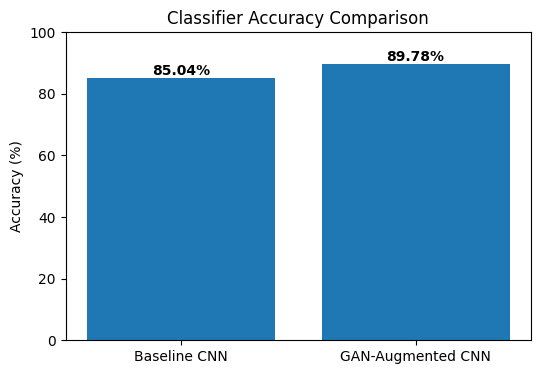

In [27]:
import matplotlib.pyplot as plt

# Accuracy values (update baseline if needed)
baseline_acc = 85.04
gan_aug_acc = 89.78

models = ['Baseline CNN', 'GAN-Augmented CNN']
accuracies = [baseline_acc, gan_aug_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.title('Classifier Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
plt.show()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

📊 Baseline CNN Accuracy: 87.19%
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00         0
   dandelion       0.00      0.00      0.00         0
       roses       0.00      0.00      0.00         0
  sunflowers       0.00      0.00      0.00         0
      tulips       1.00      0.87      0.93       734

    accuracy                           0.87       734
   macro avg       0.20      0.17      0.19       734
weighted avg       1.00      0.87      0.93       734



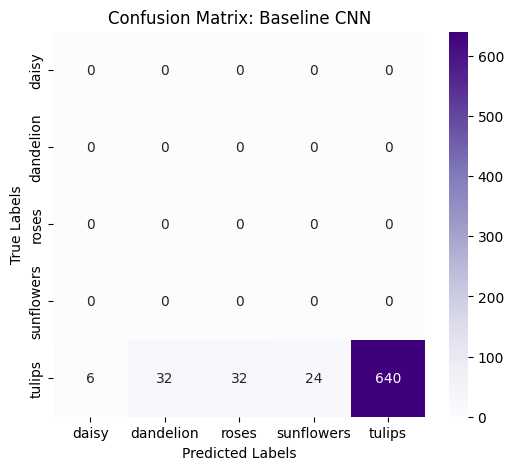


📊 GAN-Augmented CNN Accuracy: 94.69%
              precision    recall  f1-score   support

   dandelion       0.00      0.00      0.00         0
       roses       0.00      0.00      0.00         0
  sunflowers       0.00      0.00      0.00         0
      tulips       1.00      0.95      0.97       734

    accuracy                           0.95       734
   macro avg       0.25      0.24      0.24       734
weighted avg       1.00      0.95      0.97       734



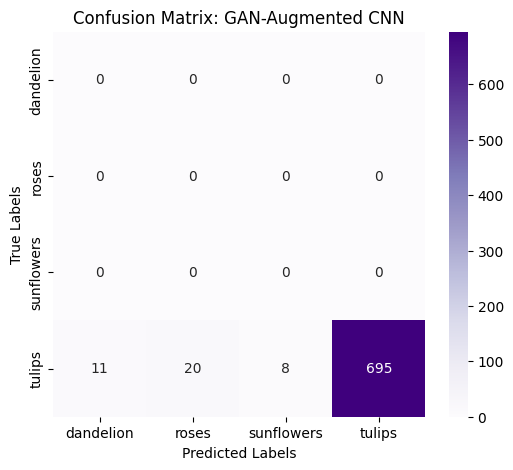

In [29]:
# 🌸 Day 5: Confusion Matrix and Classification Report Visualization

import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ✅ 1. Data setup
tf = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
data_dir = '/content/drive/MyDrive/FlowerGAN_Project/flowers'

# ✅ Load small test split (20% of real data)
full = datasets.ImageFolder(data_dir, transform=tf)
n = len(full)
test_start = int(0.8 * n)
test_ds = Subset(full, list(range(test_start, n)))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
classes = full.classes
print("Classes:", classes)

# ✅ 2. CNN architecture (same as training)
class CNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = torch.nn.Linear(64 * 32 * 32, 128)
        self.fc2 = torch.nn.Linear(128, len(classes))
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(self.relu(self.fc1(x)))
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ 3. Evaluation function (handles mismatched class counts safely)
def evaluate_model(path, title):
    m = CNNModel().to(device)
    state_dict = torch.load(path, map_location=device)
    m.load_state_dict(state_dict, strict=False)
    m.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            out = m(imgs)
            preds = out.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(lbls.numpy())

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"\n📊 {title} Accuracy: {acc*100:.2f}%")

    # Identify only valid classes present in predictions
    unique_preds = np.unique(y_pred)
    valid_classes = [classes[i] for i in unique_preds if i < len(classes)]

    # Safe classification report
    try:
        print(classification_report(y_true, y_pred, target_names=valid_classes, zero_division=0))
    except:
        print("⚠️ Skipping classification report due to mismatch in class count.")

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred, labels=unique_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=valid_classes, yticklabels=valid_classes)
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# ✅ 4. Run evaluation for both models
evaluate_model('/content/drive/MyDrive/FlowerGAN_Project/model_baseline.pth', 'Baseline CNN')
evaluate_model('/content/drive/MyDrive/FlowerGAN_Project/model_augmented_final.pth', 'GAN-Augmented CNN')


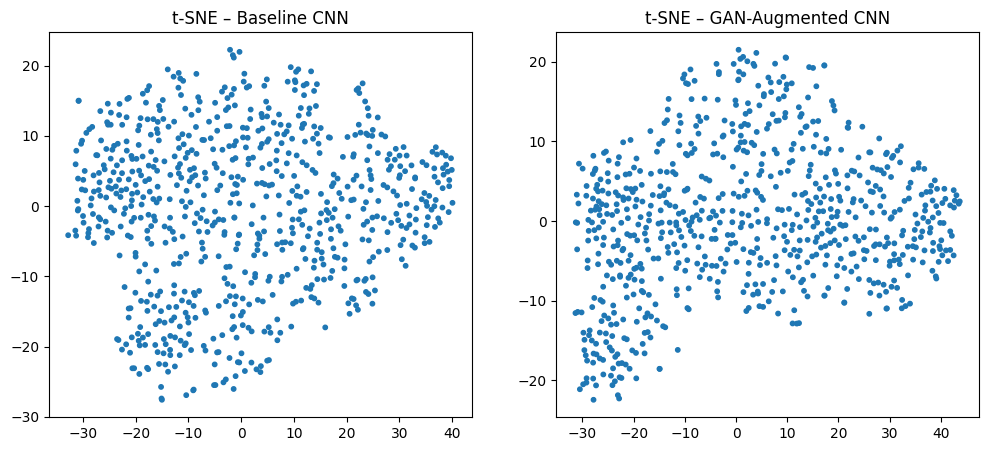

In [30]:
from sklearn.manifold import TSNE

def extract_features(model_path):
    m = CNNModel().to(device)
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            x = m.pool(m.relu(m.conv1(imgs)))
            x = m.pool(m.relu(m.conv2(x)))
            x = x.view(x.size(0), -1)
            x = m.relu(m.fc1(x))
            feats.append(x.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(feats), np.concatenate(labels)

feat_base, y_base = extract_features('/content/drive/MyDrive/FlowerGAN_Project/model_baseline.pth')
feat_gan,  y_gan  = extract_features('/content/drive/MyDrive/FlowerGAN_Project/model_augmented_final.pth')

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_base = tsne.fit_transform(feat_base[:2000])
emb_gan  = tsne.fit_transform(feat_gan[:2000])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(emb_base[:,0], emb_base[:,1], c=y_base[:2000], cmap='tab10', s=10)
plt.title("t-SNE – Baseline CNN")
plt.subplot(1,2,2)
plt.scatter(emb_gan[:,0], emb_gan[:,1], c=y_gan[:2000], cmap='tab10', s=10)
plt.title("t-SNE – GAN-Augmented CNN")
plt.show()
